In [22]:
import sys
from pathlib import Path
ROOT_DIR = Path().resolve().parents[0]
sys.path.append(str(ROOT_DIR))
import config as cfg

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

N_RUN = 3

# Training evaluation across folds

## Function definitions

In [23]:
def get_checkpoint_steps_from_fold(n_run, fold_id):
    """
	Get the list of checkpoint steps for a specific run and fold.
	This function reads the checkpoint directories for a given run and fold,
	and returns a sorted list of checkpoint steps (integers) found in those directories.
	Args:
		- n_run: The run number (integer).
		- fold_id: The fold ID (integer).
	Returns:
		- A sorted list of checkpoint steps (integers).
	"""
    # Construct the path to the fold directory based on the run number and fold ID
    path_fold_dir = os.path.join(cfg.PATH_CHECKPOINTS, cfg.MODEL_BASE, f"run_{n_run}", f"fold_{fold_id}")
    # Create a list of checkpoint directories that start with "checkpoint-"
    checkpoints = [int(folder.split("checkpoint-")[-1]) for folder in os.listdir(path_fold_dir) if folder.startswith("checkpoint")]
    return sorted(checkpoints)

In [24]:
def get_best_metric_from_fold(n_run, fold_id):
    """
	Get the best metric from the trainer state for a specific run and fold.
    """
    # Get all checkpoint steps for the specified run and fold and find the last
    # checkpoint which is the one with the highest step number.
    last_checkpoint = max(get_checkpoint_steps_from_fold(n_run, fold_id))
    
	# Construct the path to the trainer state JSON file for the last checkpoint
    path_trainer_state = os.path.join(
        cfg.PATH_CHECKPOINTS, cfg.MODEL_BASE, f"run_{n_run}", f"fold_{fold_id}",
        f"checkpoint-{last_checkpoint}", "trainer_state.json"
    )
    
	# Try to read the trainer state from the JSON file
    try:
        with open(path_trainer_state, "r") as f:
            trainer_state = json.load(f)
        return trainer_state["best_metric"]
    except FileNotFoundError:
        print(f"File not found: {path_trainer_state}")
        return None

## Metrics calculation

In [36]:
# Get the best roc_auc_macro from each fold
fold_scores = {fold_id: get_best_metric_from_fold(N_RUN, fold_id) for fold_id in range(cfg.N_FOLDS)}
# Create a DataFrame to store the fold scores
df_auc_scores = pd.DataFrame.from_dict(fold_scores, orient='index', columns=['ROC-AUC-macro'])
# Add new rows for mean and standard deviation of ROC-AUC-macro
df_auc_scores = pd.concat(
    [
		df_auc_scores,
		pd.DataFrame(
            {
                "ROC-AUC-macro": [
					df_auc_scores["ROC-AUC-macro"].mean(),
					df_auc_scores["ROC-AUC-macro"].std()
				]
            },
            index=['mean (ROC-AUC-macro)', 'std']
		)
	]
)
df_auc_scores.index.name = 'Fold'
# Create the path to save the DataFrame with AUC scores
path_df_auc_scores = os.path.join(
    cfg.PATH_RESULTS, cfg.MODEL_BASE, f"run_{N_RUN}", "evaluation", "folds_scores_roc_auc.csv"
)
# Ensure the directory exists before saving the DataFrame
os.makedirs(os.path.dirname(path_df_auc_scores), exist_ok=True)
# Save the DataFrame to a CSV file
df_auc_scores.to_csv(path_df_auc_scores)
df_auc_scores

,ROC-AUC-macro
Fold,
0,0.988334
1,0.990360
2,0.986783
3,0.987921
4,0.989214
mean (ROC-AUC-macro),0.988522
std,0.001349


## Conclusions

The ROC AUC macro scores across the five folds are very high, with a mean of approximately 0.988522.

Moreover, the small standard deviation (~0.001206) indicates minimal variation between the folds. This suggests not only that the model performs well when generalizing, but also that these strong results are not dependent on any particular data split.

We can conclude that the model generalizes exceptionally well.

# Learning and ROC-AUC curves

## Get data for plots

In [19]:
# Collect training and validation metrics from all folds given a specific run.
# This will create a DataFrame with the training and validation metrics per fold.
rows = []
for fold_id in range(cfg.N_FOLDS):
    # Construct the path to the log history JSON file for the current fold
    path_log_history = os.path.join(cfg.PATH_CHECKPOINTS, cfg.MODEL_BASE, f"run_{N_RUN}", f"fold_{fold_id}", "log_history.json")
    # Read the log history from the JSON file
    with open(path_log_history, "r") as f:
        log_history = json.load(f)
	# Iterate through the log history and extract relevant metrics
    for log in log_history:
        row = {}
        row["fold"] = fold_id
        row["step"] = log.get("step", None)
        row["epoch"] = log.get("epoch", None)
        row["train_loss"] = log.get("loss", None)
        row["val_loss"] = log.get("eval_loss", None)
        row["train_roc_auc_macro"] = log.get("train_roc_auc_macro", None)
        row["val_roc_auc_macro"] = log.get("eval_roc_auc_macro", None)
        rows.append(row)
# Create a DataFrame from the collected rows
df = pd.DataFrame(rows)
df

,fold,step,epoch,train_loss,val_loss,train_roc_auc_macro,val_roc_auc_macro
0,0,10,0.002506,0.6765,NaN,NaN,NaN
1,0,20,0.005013,0.6209,NaN,NaN,NaN
2,0,30,0.007519,0.5311,NaN,NaN,NaN
3,0,40,0.010025,0.4128,NaN,NaN,NaN
4,0,50,0.012531,0.3119,NaN,NaN,NaN
...,...,...,...,...,...,...,...
4828,4,8490,2.127820,0.0354,NaN,NaN,NaN
4829,4,8500,2.130326,0.0373,NaN,NaN,NaN
4830,4,8500,2.130326,NaN,0.03829,NaN,0.988885
4831,4,8500,2.130326,NaN,NaN,0.993216,NaN


In [20]:
# As per the log history dessign, each step multiple of the `cfg.EVAL_STEPS`
# gets logged tree times, so we can group by fold and step and take the first
# non-null value for each metric.
df = df.groupby(["fold", "step"]).agg(lambda x: x.dropna().iloc[0] if not x.dropna().empty else None).reset_index()
df = df.dropna(subset=[col for col in df.columns][3:], how="all")
df

,fold,step,epoch,train_loss,val_loss,train_roc_auc_macro,val_roc_auc_macro
0,0,10,0.002506,0.6765,NaN,NaN,NaN
1,0,20,0.005013,0.6209,NaN,NaN,NaN
2,0,30,0.007519,0.5311,NaN,NaN,NaN
3,0,40,0.010025,0.4128,NaN,NaN,NaN
4,0,50,0.012531,0.3119,NaN,NaN,NaN
...,...,...,...,...,...,...,...
4467,4,8460,2.120301,0.0401,NaN,NaN,NaN
4468,4,8470,2.122807,0.0242,NaN,NaN,NaN
4469,4,8480,2.125313,0.0332,NaN,NaN,NaN
4470,4,8490,2.127820,0.0354,NaN,NaN,NaN


## Plot results

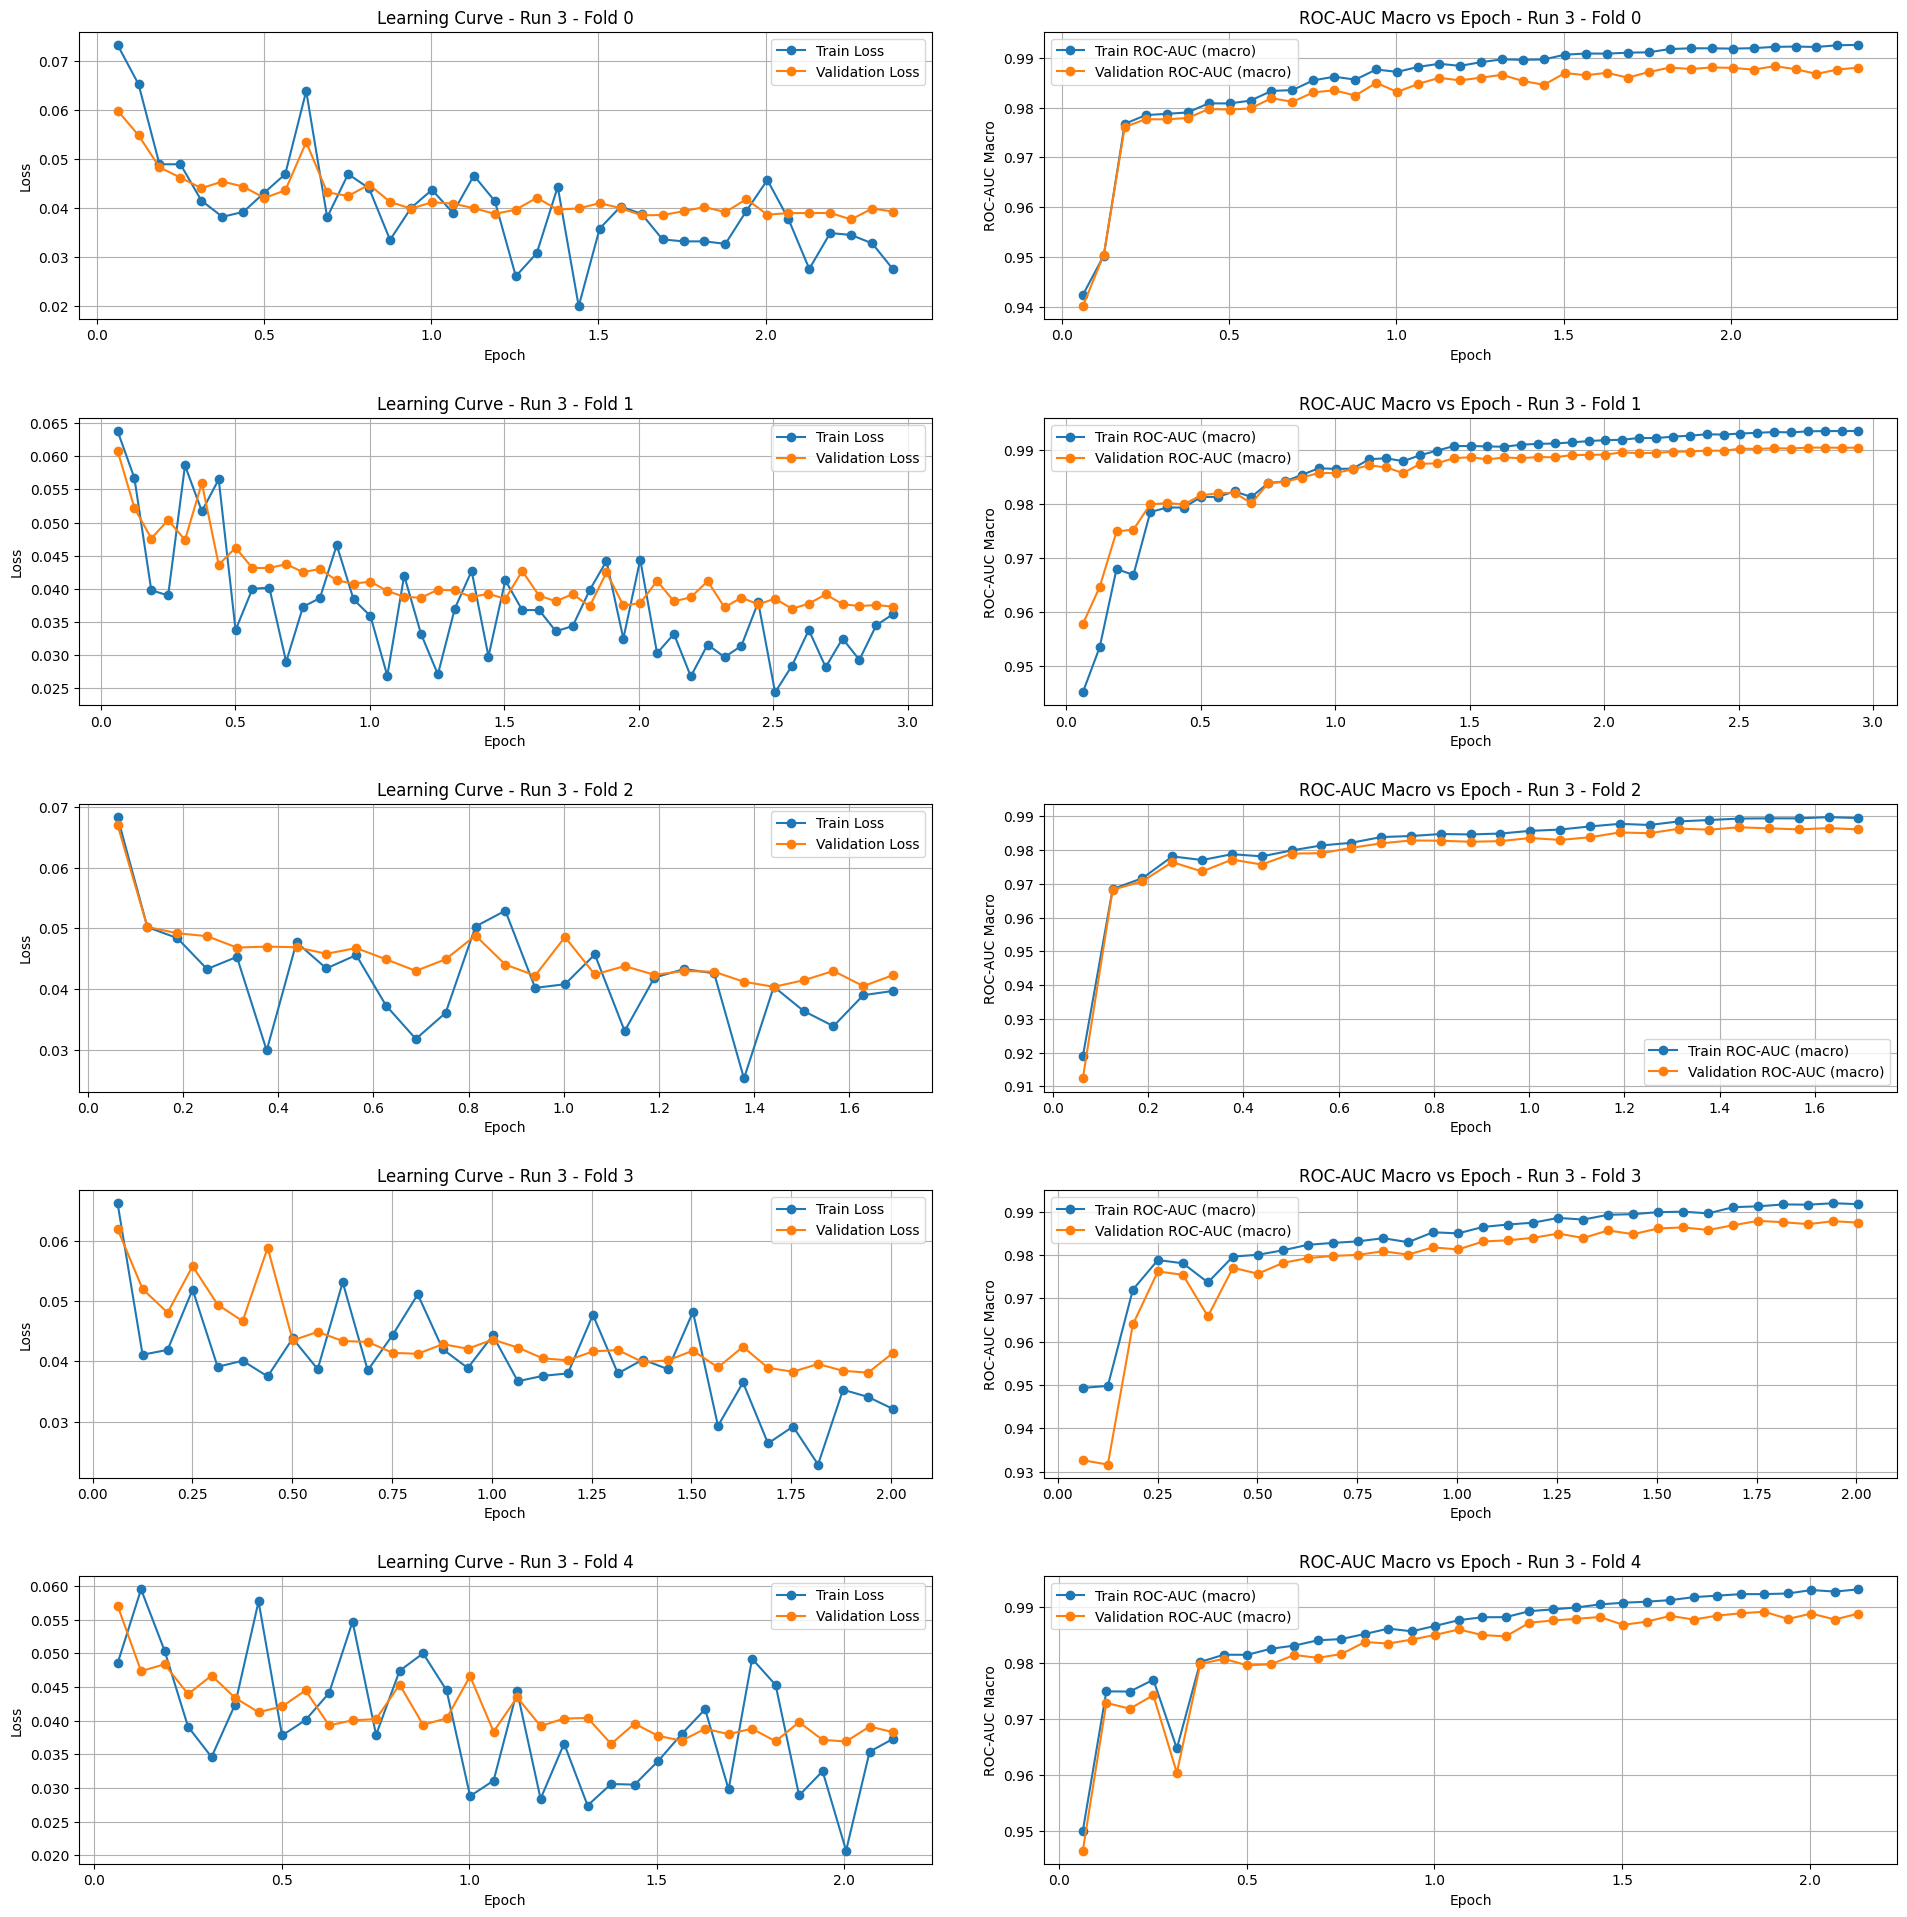

In [21]:
fig, axes = plt.subplots(nrows=cfg.N_FOLDS, ncols=2, figsize=(20, 20))
fig.tight_layout(pad=5.0)

for fold_id in range(cfg.N_FOLDS):
    # Filter data based on fold_id
    df_fold = df[(df["fold"] == fold_id) & (df["step"] % cfg.EVAL_STEPS == 0)]

    # Fix x axes in which to plot
    ax_loss = axes[fold_id, 0]
    ax_auc = axes[fold_id, 1]

    # First plot: train_loss and val_loss vs epoch
    ax_loss.plot(df_fold["epoch"], df_fold["train_loss"], marker="o", label="Train Loss")
    ax_loss.plot(df_fold["epoch"], df_fold["val_loss"], marker="o", label="Validation Loss")
    ax_loss.set_title(f"Learning Curve - Run {N_RUN} - Fold {fold_id}")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Loss")
    ax_loss.legend()
    ax_loss.grid(True)

    # Second plot: val_roc_auc_macro vs epoch
    ax_auc.plot(df_fold["epoch"], df_fold["train_roc_auc_macro"], marker="o", label="Train ROC-AUC (macro)")
    ax_auc.plot(df_fold["epoch"], df_fold["val_roc_auc_macro"], marker="o", label="Validation ROC-AUC (macro)")
    ax_auc.set_title(f"ROC-AUC Macro vs Epoch - Run {N_RUN} - Fold {fold_id}")
    ax_auc.set_xlabel("Epoch")
    ax_auc.set_ylabel("ROC-AUC Macro")
    ax_auc.legend()
    ax_auc.grid(True)

# Create the path to save the figure dinamically based on the run number
path_figure_save = os.path.join(
      cfg.PATH_RESULTS, cfg.MODEL_BASE, f"run_{N_RUN}", "evaluation", "learning_and_ROC-AUC_curves.png"
)
# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(path_figure_save), exist_ok=True)
# Save the figure to a file
plt.savefig(path_figure_save, bbox_inches='tight', dpi=300)

# Show all the plots
plt.show()

## Conclusions

The graphs show how all the folds begin to converge around epoch 2, which is also when several folds stop training due to the early stopping configuration.

The small gap between the training and validation curves indicates that the model is generalizing well.